# &#x1F4D1; &nbsp;  Digit Recognition Models

## Links
[`SciPy. Multi-dimensional image processing`](https://docs.scipy.org/doc/scipy/reference/ndimage.html)

[`Keras. Deep Learning library for Theano and TensorFlow`](https://keras.io/)
 
[`TensorFlow. Deep MNIST for Experts`](https://www.tensorflow.org/get_started/mnist/pros)

[`Tensorflow. Deep MNIST Advanced Tutorial`](http://docs.seldon.io/tensorflow-deep-mnist-example.html)

[`Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras`](http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)

## Libraries

In [1]:
%%html
<style>        
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;} 
</style>

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
from time import time

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML, display

import matplotlib.pylab as plt
import matplotlib.cm as cm

import cv2

%matplotlib inline

In [3]:
from skimage import transform

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model, neighbors, svm, ensemble
from sklearn import datasets, metrics 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.decomposition import PCA

In [34]:
import keras as ks
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM, ConvLSTM2D, Reshape
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers import AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.embeddings import Embedding
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.vgg16 import VGG16 
from keras.applications.vgg19 import VGG19

In [6]:
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:', tf.__version__)

keras version: 2.1.6
tensorflow version: 1.8.0


## Dataset

In [7]:
df_train = pd.read_csv("kaggle_digits_train.csv")
df_test = pd.read_csv("kaggle_digits_test.csv")
df_train.shape

(42000, 785)

In [8]:
df_train.ix[15:20,15:20]

,pixel14,pixel15,pixel16,pixel17,pixel18
15,0,0,0,0,0
16,0,0,0,0,0
17,0,0,0,0,0
18,0,0,0,0,0
19,0,0,0,0,0
20,0,0,0,0,0


In [9]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,784)]
train_images = np.array(df_train[images])
train_images = train_images.astype('float32')/255
train_images.shape

(42000, 784)

In [10]:
train_labels = df_train['label']
train_labels_cat = ks.utils.to_categorical(train_labels, num_classes=10)
train_labels_cat.shape

(42000, 10)

In [11]:
test_images = np.array(df_test[images])
test_images = test_images.astype('float32')/255
test_images.shape

(28000, 784)

## Possible Preprocessing

In [12]:
def find_borders(x):
    left, right, top, bottom = [], [], [], []
    
    for k in range(x.shape[0]):
        
        for j in range(28):
            for i in range(28):
                if (x[k,28*i+j] >= 0.4):
                    left.append(j)
                    break
            if (len(left) > k):
                break
                
        for j in range(28):
            for i in range(28):
                if (x[k, 28*i+(28-1-j)] >= 0.4):
                    right.append(28-1-j)
                    break
            if (len(right) > k):
                break 
                
        for i in range(28):
            for j in range(28):
                if (x[k,28*i+j] >= 0.4):
                    top.append(i)
                    break
            if (len(top) > k):
                break 
                
        for i in range(28):
            for j in range(28):
                if (x[k,28*(28-1-i)+j] >= 0.4):
                    bottom.append(28-1-i)
                    break
            if (len(bottom) > k):
                break       
        
    return left, right, top, bottom

In [13]:
def resize_images(x):
    left, right, top, bottom = find_borders(x)    
    x = x.reshape(-1,28,28)
    
    for i in range(x.shape[0]):      
        x[i] = transform.resize(x[i][top[i]:bottom[i]+1,left[i]:right[i]+1],(28,28))
#        x[i] = transform.resize(x[i][top[i]:bottom[i]+1,left[i]:right[i]+1],(24,24))    
    return(x.reshape(-1,28**2))
#    return(x.reshape(-1,24**2))

In [14]:
# train_images = resize_images(train_images)
# test_images = resize_images(test_images)
# train_images.shape, test_images.shape

In [15]:
def variance_threshold(train, test):
    selector = VarianceThreshold(threshold=0).fit(train)
    train = selector.transform(train)
    test = selector.transform(test)
    return train, test

In [16]:
# train_images, test_images = variance_threshold(train_images, test_images)
# train_images.shape, test_images.shape

In [17]:
def select_kbest(train, train_categories, test):
    selector = SelectKBest(chi2, k=512).fit(train, train_categories)
    train = selector.transform(train)
    test = selector.transform(test)
    return train, test

In [18]:
# train_images, test_images = select_kbest(train_images, train_labels, test_images)
# train_images.shape, test_images.shape

In [19]:
def pca(train, test):
    pca = PCA(n_components=0.95)
    pca.fit(train)
    train = pca.transform(train)
    test = pca.transform(test)
    return train, test

In [20]:
# train_images, test_images = pca(train_images, test_images)
# train_images.shape, test_images.shape

In [39]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_cat, 
                                                    test_size=0.2, random_state=32)

In [40]:
n = int(len(X_test)/2)
X_valid, y_valid = X_test[:n], y_test[:n]
X_test, y_test = X_test[n:], y_test[n:]
X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((33600, 784), (4200, 784), (4200, 784), (33600, 10), (4200, 10), (4200, 10))

In [41]:
y_train_num = np.array([np.argmax(x) for x in y_train])
y_test_num = np.array([np.argmax(x) for x in y_test])
y_valid_num = np.array([np.argmax(x) for x in y_valid])

In [42]:
X_train_app = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in X_train]
X_train_app = np.concatenate([arr[np.newaxis] for arr in X_train_app]).astype('float32')

X_test_app = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in X_test]
X_test_app = np.concatenate([arr[np.newaxis] for arr in X_test_app]).astype('float32')

X_valid_app = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in X_valid]
X_valid_app = np.concatenate([arr[np.newaxis] for arr in X_valid_app]).astype('float32')

In [43]:
X_train_app.shape, X_test_app.shape, X_valid_app.shape, y_train.shape, y_test.shape, y_valid.shape

((33600, 32, 32, 3),
 (4200, 32, 32, 3),
 (4200, 32, 32, 3),
 (33600, 10),
 (4200, 10),
 (4200, 10))

## Examples

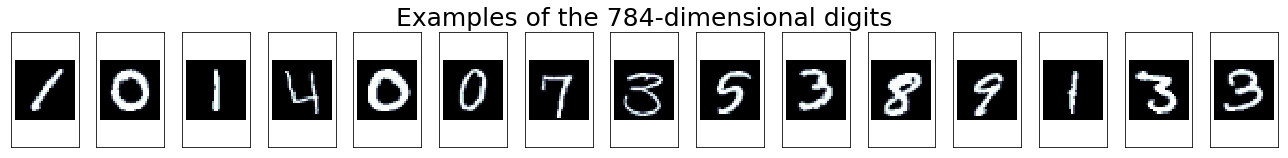

In [44]:
fig, ax = plt.subplots(figsize=(18, 2), nrows=1, ncols=15, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(15):
    image = train_images[i].reshape(28,28)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[7].set_title('Examples of the 784-dimensional digits', fontsize=25);

In [45]:
X_train_tensor = tf.image.grayscale_to_rgb(X_train.reshape(-1, 28, 28, 1), name=None)
X_test_tensor = tf.image.grayscale_to_rgb(X_test.reshape(-1, 28, 28, 1), name=None)
X_valid_tensor = tf.image.grayscale_to_rgb(X_valid.reshape(-1, 28, 28, 1), name=None)

In [46]:
sess = tf.Session()
with sess.as_default():
    X_train_color = X_train_tensor.eval()
    X_test_color = X_test_tensor.eval()
    X_valid_color = X_valid_tensor.eval()

In [47]:
X_train_color.shape, X_test_color.shape, X_valid_color.shape

((33600, 28, 28, 3), (4200, 28, 28, 3), (4200, 28, 28, 3))

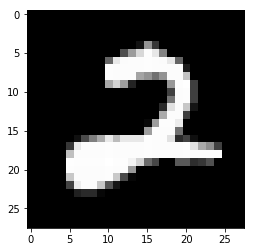

In [48]:
plt.imshow(X_test_color[0]);

## Neural Network Models

### Model #1. Convolutional Neural Network. Keras

In [49]:
 def cnn_mc_model():
    model_input = Input(shape=(28, 28, 1))
    x = BatchNormalization()(model_input)
    
    x = Conv2D(28, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (5, 5))(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(strides=(2, 2))(x)
    x = Dropout(0.25)(x)   

    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = Dropout(0.5)(x)
    
#    x = Reshape((1, 128), input_shape=(128,))(x)
#    x = LSTM(128, activation='relu')(x)
    
    y = Dense(10, activation='softmax')(x)
    
    model = Model(input=model_input, output=y)
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cnn_mc_model = cnn_mc_model()

In [50]:
cnn_checkpointer = ModelCheckpoint(filepath='weights.best3.cnn_mc.digits.hdf5', 
                                   verbose=2, save_best_only=True)
cnn_lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                     patience=5, verbose=2, 
                                     factor=0.5, min_lr=0.000001)

fit_cnn = cnn_mc_model.fit(X_train.reshape(-1, 28, 28, 1), y_train, 
                           validation_data=(X_valid.reshape(-1, 28, 28, 1), y_valid), 
                           epochs=50, batch_size=128, verbose=2, 
                           callbacks=[cnn_checkpointer, cnn_lr_reduction])

Train on 33600 samples, validate on 4200 samples
Epoch 1/50
 - 104s - loss: 0.4097 - acc: 0.8649 - val_loss: 0.0731 - val_acc: 0.9802

Epoch 00001: val_loss improved from inf to 0.07309, saving model to weights.best3.cnn_mc.digits.hdf5
Epoch 2/50
 - 92s - loss: 0.0905 - acc: 0.9718 - val_loss: 0.0553 - val_acc: 0.9836

Epoch 00002: val_loss improved from 0.07309 to 0.05532, saving model to weights.best3.cnn_mc.digits.hdf5
Epoch 3/50
 - 93s - loss: 0.0673 - acc: 0.9787 - val_loss: 0.0593 - val_acc: 0.9840

Epoch 00003: val_loss did not improve from 0.05532
Epoch 4/50
 - 90s - loss: 0.0584 - acc: 0.9812 - val_loss: 0.0470 - val_acc: 0.9874

Epoch 00004: val_loss improved from 0.05532 to 0.04698, saving model to weights.best3.cnn_mc.digits.hdf5
Epoch 5/50
 - 90s - loss: 0.0524 - acc: 0.9832 - val_loss: 0.0539 - val_acc: 0.9855

Epoch 00005: val_loss did not improve from 0.04698
Epoch 6/50
 - 91s - loss: 0.0448 - acc: 0.9857 - val_loss: 0.0417 - val_acc: 0.9879

Epoch 00006: val_loss impro

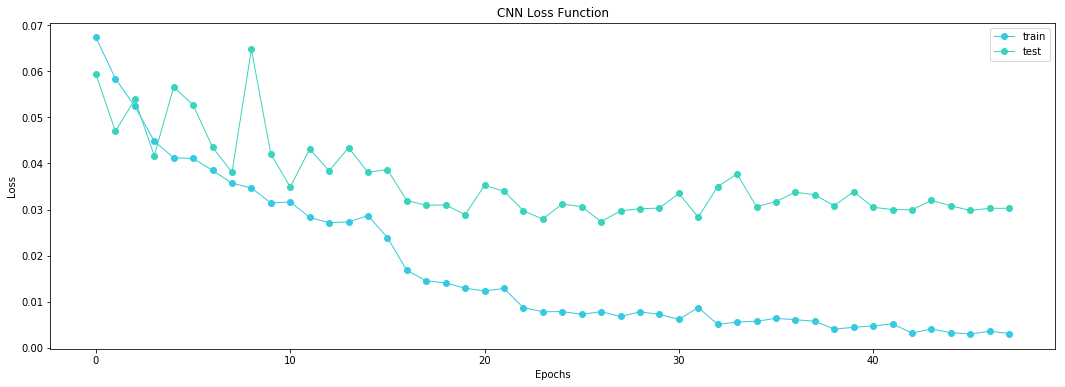

In [51]:
plt.figure(figsize=(18, 6))
plt.plot(fit_cnn.history['loss'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_cnn.history['val_loss'][2:], '-o', c='#39d4be', lw=1, label = 'test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Loss Function');

In [52]:
cnn_mc_model.load_weights('weights.best3.cnn_mc.digits.hdf5')
cnn_scores = cnn_mc_model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test, verbose=0)

print("CNN Scores: " , (cnn_scores))
print("CNN Error: %.2f%%" % (100 - cnn_scores[1]*100))
print(cnn_mc_model.summary())

CNN Scores:  [0.02339021104894008, 0.9935714285714285]
CNN Error: 0.64%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 28)        728       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 28)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 28)        0         
_________________________________________________________________
conv

In [ ]:
data_generator = ImageDataGenerator(zoom_range=0.2, 
                                    shear_range=0.2, 
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2)

fit_dg_cnn = cnn_mc_model.fit_generator(data_generator.flow(X_train.reshape(-1, 28, 28, 1), 
                                                            y_train, 
                                                            batch_size=128),
                                        steps_per_epoch = 1000, epochs = 50, verbose=2,
                                        validation_data = (X_valid.reshape(-1, 28, 28, 1), y_valid), 
                                        callbacks=[cnn_checkpointer, cnn_lr_reduction])

Epoch 1/50

Epoch 00001: val_loss did not improve
 - 422s - loss: 0.0414 - acc: 0.9874 - val_loss: 0.0242 - val_acc: 0.9945
Epoch 2/50

Epoch 00002: val_loss did not improve
 - 407s - loss: 0.0413 - acc: 0.9875 - val_loss: 0.0318 - val_acc: 0.9929
Epoch 3/50

Epoch 00003: val_loss did not improve
 - 405s - loss: 0.0388 - acc: 0.9882 - val_loss: 0.0274 - val_acc: 0.9960
Epoch 4/50

Epoch 00004: val_loss did not improve
 - 444s - loss: 0.0383 - acc: 0.9889 - val_loss: 0.0272 - val_acc: 0.9940
Epoch 5/50

Epoch 00005: val_loss did not improve
 - 465s - loss: 0.0397 - acc: 0.9882 - val_loss: 0.0256 - val_acc: 0.9943
Epoch 6/50

Epoch 00006: val_loss did not improve
 - 486s - loss: 0.0400 - acc: 0.9880 - val_loss: 0.0264 - val_acc: 0.9952
Epoch 7/50

Epoch 00007: val_loss did not improve
 - 472s - loss: 0.0411 - acc: 0.9880 - val_loss: 0.0278 - val_acc: 0.9943
Epoch 8/50

Epoch 00008: val_loss did not improve
 - 505s - loss: 0.0394 - acc: 0.9884 - val_loss: 0.0265 - val_acc: 0.9950
Epoch 9/

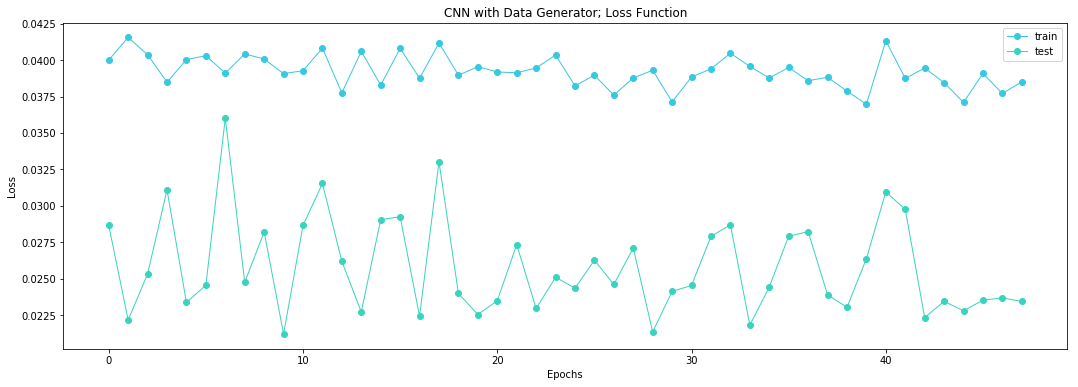

In [21]:
plt.figure(figsize=(18, 6))
plt.plot(fit_dg_cnn.history['loss'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_dg_cnn.history['val_loss'][2:], '-o', c='#39d4be', lw=1, label = 'test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN with Data Generator; Loss Function');

In [22]:
cnn_mc_model.load_weights('weights.best3.cnn_mc.digits.hdf5')
cnn_scores = cnn_mc_model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test, verbose=0)

print("CNN with Data Generator; Scores: " , (cnn_scores))
print("CNN with Data Generator; Error: %.2f%%" % (100 - cnn_scores[1]*100))

CNN with Data Generator; Scores:  [0.016435499350774901, 0.99523809523809526]
CNN with Data Generator; Error: 0.48%


In [79]:
cnn_mc_model.save('kaggle_digits_cnn_mc_model3.h5')

### Model #2. Multi-layer Perceptron. Keras

In [44]:
def mlp_mc_model():
    model = Sequential()

    model.add(Dense(1568, activation='relu', input_shape = X_train.shape[1:]))
    model.add(Dropout(0.2))
    
    model.add(Dense(392, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mlp_mc_model = mlp_mc_model()

In [45]:
mlp_checkpointer = ModelCheckpoint(filepath='weights.best.mlp_mc.digits.hdf5', 
                                   verbose=2, save_best_only=True)
fit_mlp = mlp_mc_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                           epochs=15, batch_size=128, verbose=2, callbacks=[mlp_checkpointer]);

Train on 33600 samples, validate on 4200 samples
Epoch 1/15
Epoch 00000: val_loss improved from inf to 0.17868, saving model to weights.best.mlp_mc.digits.hdf5
41s - loss: 0.3167 - acc: 0.9030 - val_loss: 0.1787 - val_acc: 0.9483
Epoch 2/15
Epoch 00001: val_loss did not improve
26s - loss: 0.1289 - acc: 0.9619 - val_loss: 0.3036 - val_acc: 0.9176
Epoch 3/15
Epoch 00002: val_loss improved from 0.17868 to 0.13932, saving model to weights.best.mlp_mc.digits.hdf5
26s - loss: 0.0983 - acc: 0.9709 - val_loss: 0.1393 - val_acc: 0.9636
Epoch 4/15
Epoch 00003: val_loss improved from 0.13932 to 0.10798, saving model to weights.best.mlp_mc.digits.hdf5
26s - loss: 0.0773 - acc: 0.9761 - val_loss: 0.1080 - val_acc: 0.9686
Epoch 5/15
Epoch 00004: val_loss improved from 0.10798 to 0.10275, saving model to weights.best.mlp_mc.digits.hdf5
26s - loss: 0.0660 - acc: 0.9794 - val_loss: 0.1027 - val_acc: 0.9729
Epoch 6/15
Epoch 00005: val_loss did not improve
28s - loss: 0.0575 - acc: 0.9816 - val_loss: 0.

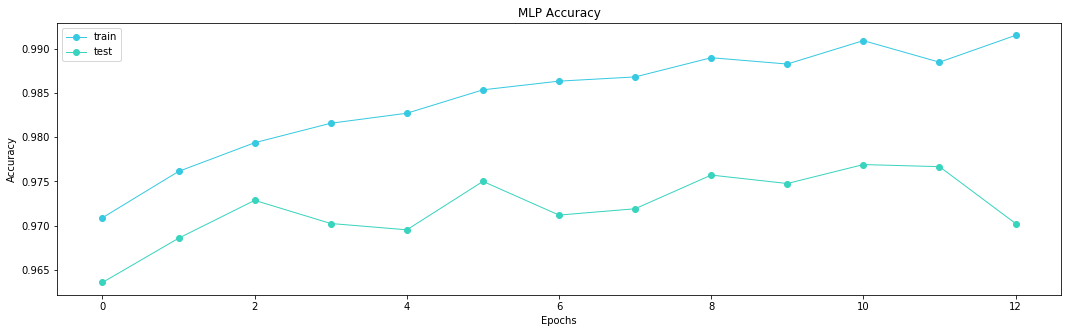

In [47]:
plt.figure(figsize=(18,5))
plt.plot(fit_mlp.history['acc'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_mlp.history['val_acc'][2:], '-o', c='#39d4be', lw=1, label = 'test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MLP Accuracy');

In [48]:
mlp_mc_model.load_weights('weights.best.mlp_mc.digits.hdf5')
mlp_scores = mlp_mc_model.evaluate(X_test, y_test)

print("\nMLP Scores: ", (mlp_scores))
print("MLP Error: %.2f%%" % (100 - mlp_scores[1] * 100))
print(mlp_mc_model.summary())

4128/4200 [============================>.] - ETA: 0s
MLP Scores:  [0.078916780660594155, 0.97833333333333339]
MLP Error: 2.17%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1568)              1230880   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1568)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 392)               615048    
_________________________________________________________________
dropout_14 (Dropout)         (None, 392)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               50304     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_______________

In [49]:
mlp_mc_model.save('kaggle_digits_mlp_mc_model.h5')

### Model #3. Recurrent Neural Network. Keras

In [50]:
def rnn_mc_model():
    model = Sequential()

    model.add(LSTM(196, return_sequences=True, input_shape=(1, 784)))    
    model.add(LSTM(196, return_sequences=True))
    
    model.add(LSTM(784))  
    
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])    
    return model 

In [51]:
rnn_mc_model = rnn_mc_model()
rnn_checkpointer = ModelCheckpoint(filepath='weights.best.rnn_mc.digits.hdf5', 
                                   verbose=2, save_best_only=True)
fit_rnn = rnn_mc_model.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1]), y_train, 
                           epochs=10, batch_size=128, verbose=2, callbacks=[rnn_checkpointer],
                           validation_data=(X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1]), y_valid))

Train on 33600 samples, validate on 4200 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 0.15715, saving model to weights.best.rnn_mc.digits.hdf5
154s - loss: 0.3552 - acc: 0.8871 - val_loss: 0.1571 - val_acc: 0.9505
Epoch 2/10
Epoch 00001: val_loss improved from 0.15715 to 0.11661, saving model to weights.best.rnn_mc.digits.hdf5
138s - loss: 0.1180 - acc: 0.9631 - val_loss: 0.1166 - val_acc: 0.9621
Epoch 3/10
Epoch 00002: val_loss did not improve
143s - loss: 0.0746 - acc: 0.9756 - val_loss: 0.1215 - val_acc: 0.9648
Epoch 4/10
Epoch 00003: val_loss improved from 0.11661 to 0.09947, saving model to weights.best.rnn_mc.digits.hdf5
136s - loss: 0.0521 - acc: 0.9830 - val_loss: 0.0995 - val_acc: 0.9714
Epoch 5/10
Epoch 00004: val_loss did not improve
131s - loss: 0.0380 - acc: 0.9868 - val_loss: 0.1331 - val_acc: 0.9655
Epoch 6/10
Epoch 00005: val_loss did not improve
125s - loss: 0.0287 - acc: 0.9896 - val_loss: 0.1202 - val_acc: 0.9695
Epoch 7/10
Epoch 00006: val_loss did 

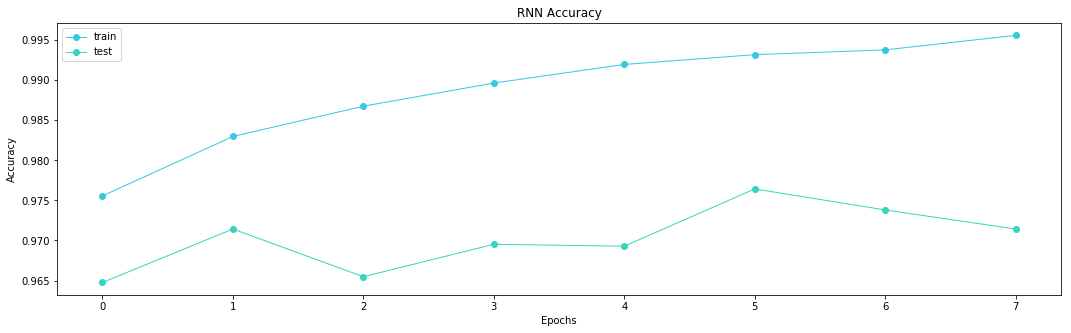

In [52]:
plt.figure(figsize=(18,5))
plt.plot(fit_rnn.history['acc'][2:], '-o', c='#37c9e1', lw=1, label = 'train')
plt.plot(fit_rnn.history['val_acc'][2:], '-o', c='#39d4be', lw=1, label = 'test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('RNN Accuracy');

In [53]:
rnn_mc_model.load_weights('weights.best.rnn_mc.digits.hdf5')
rnn_scores = rnn_mc_model.evaluate(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test)

print("\nRNN Scores: ", (rnn_scores))
print("RNN Error: %.2f%%" % (100 - rnn_scores[1] * 100))
print(rnn_mc_model.summary())

4200/4200 [==============================] - 5s     

RNN Scores:  [0.077274715628120161, 0.97571428571428576]
RNN Error: 2.43%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 196)            769104    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 196)            308112    
_________________________________________________________________
lstm_3 (LSTM)                (None, 784)               3076416   
_________________________________________________________________
dense_13 (Dense)             (None, 10)                7850      
Total params: 4,161,482
Trainable params: 4,161,482
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
rnn_mc_model.save('kaggle_digits_rnn_mc_model.h5')

### Model #4. MLPClassifier. Scikit-Learn

In [91]:
clf = MLPClassifier(hidden_layer_sizes=(784,), max_iter=50, alpha=1e-4,
                     solver='adam', verbose=1, tol=1e-6, random_state=1,
                     learning_rate_init=7e-4, batch_size=128)
clf.fit(X_train, y_train);

Iteration 1, loss = 0.94378841
Iteration 2, loss = 0.40011765
Iteration 3, loss = 0.28336239
Iteration 4, loss = 0.21722986
Iteration 5, loss = 0.17410363
Iteration 6, loss = 0.14131103
Iteration 7, loss = 0.11730296
Iteration 8, loss = 0.09752419
Iteration 9, loss = 0.08076081
Iteration 10, loss = 0.06640700
Iteration 11, loss = 0.05535066
Iteration 12, loss = 0.04585736
Iteration 13, loss = 0.03845437
Iteration 14, loss = 0.03147112
Iteration 15, loss = 0.02565168
Iteration 16, loss = 0.02093476
Iteration 17, loss = 0.01767376
Iteration 18, loss = 0.01517816
Iteration 19, loss = 0.01263184
Iteration 20, loss = 0.01070031
Iteration 21, loss = 0.00873292
Iteration 22, loss = 0.00763798
Iteration 23, loss = 0.00644964
Iteration 24, loss = 0.00566928
Iteration 25, loss = 0.00514124
Iteration 26, loss = 0.00476469
Iteration 27, loss = 0.00401193
Iteration 28, loss = 0.00387241
Iteration 29, loss = 0.02353646
Iteration 30, loss = 0.00877345
Iteration 31, loss = 0.00362994
Iteration 32, los

In [92]:
print("MNIST. MLPClassifier. Train score: %f" % (clf.score(X_train, y_train)*100),'%')
print("MNIST. MLPClassifier. Test score: %f" % (clf.score(X_test, y_test)*100),'%')

MNIST. MLPClassifier. Train score: 100.000000 %
MNIST. MLPClassifier. Test score: 96.380952 %


In [93]:
clf2 = MLPClassifier(hidden_layer_sizes=(784,), max_iter=50, alpha=1e-4,
                     solver='lbfgs', verbose=1, tol=1e-6, random_state=1,
                     learning_rate_init=7e-4, batch_size=128)
clf2.fit(X_train, y_train_num);

In [94]:
print("MNIST. MLPClassifier. Train score: %f" % (clf2.score(X_train, y_train_num)*100),'%')
print("MNIST. MLPClassifier. Test score: %f" % (clf2.score(X_test, y_test_num)*100),'%')

MNIST. MLPClassifier. Train score: 98.092262 %
MNIST. MLPClassifier. Test score: 96.916667 %


## Classifiers

In [175]:
classifier_list = []
classifier_names = []
clf_datasets = []

acc_train, acc_test = [], []
loss_train, loss_test = [], []

In [176]:
def classifier_fit_score(classifier, classifier_name, clf_dataset, x_train, x_test, y_train, y_test):
    classifier_list.append(str(classifier))
    classifier_names.append(str(classifier_name))
    clf_datasets.append(str(clf_dataset))
    
    clf = classifier
    clf.fit(x_train, y_train)
    
    y_clf_train = clf.predict(x_train)
    y_clf_test = clf.predict(x_test)
        
    acc_clf_train = round(metrics.accuracy_score(y_train, y_clf_train), 4)
    acc_train.append(acc_clf_train)
    acc_clf_test = round(metrics.accuracy_score(y_test, y_clf_test), 4)
    acc_test.append(acc_clf_test)
    
    loss_clf_train = round(metrics.hamming_loss(y_train, y_clf_train), 4)
    loss_train.append(loss_clf_train)
    loss_clf_test = round(metrics.hamming_loss(y_test, y_clf_test), 4)
    loss_test.append(loss_clf_test)
    
    return [y_clf_train, y_clf_test, acc_clf_train, acc_clf_test, loss_clf_train, loss_clf_test]

In [177]:
def get_classifier_results():
    df_results = pd.DataFrame({'classifier' : classifier_list,
                               'classifier_name': classifier_names,
                               'clf_dataset': clf_datasets,
                               'acc_train': acc_train, 
                               'acc_test': acc_test,
                               'loss_train': loss_train, 
                               'loss_test': loss_test})
    
    df_list = ['classifier_name', 'acc_train', 'acc_test', 'loss_train', 'loss_test']
               
    return df_results, df_results[df_list]

In [178]:
clf1 = neighbors.KNeighborsClassifier()
clf2 = linear_model.LogisticRegressionCV() 
clf3 = ensemble.GradientBoostingClassifier()

In [179]:
y_knc_train, y_knc_test = classifier_fit_score(clf1, 'KNeighborsClassifier', 'digits',
                                               X_train, X_test, y_train_num, y_test_num)[:2]

In [180]:
y_lrcvc_train, y_lrcvc_test = classifier_fit_score(clf2, 'LogisticRegressionCV', 'digits',
                                                   X_train, X_test, y_train_num, y_test_num)[:2]

In [181]:
y_gbc_train, y_gbc_test = classifier_fit_score(clf3, 'GradientBoostingClassifier', 'digits',
                                               X_train, X_test, y_train_num, y_test_num)[:2]

In [182]:
df_results, df_results2  = get_classifier_results()
df_results2.sort_values('acc_test', ascending=False)

,classifier_name,acc_train,acc_test,loss_train,loss_test
0,KNeighborsClassifier,0.9778,0.9657,0.0222,0.0343
2,GradientBoostingClassifier,0.9676,0.9440,0.0324,0.0560
1,LogisticRegressionCV,0.9282,0.9177,0.0718,0.0823


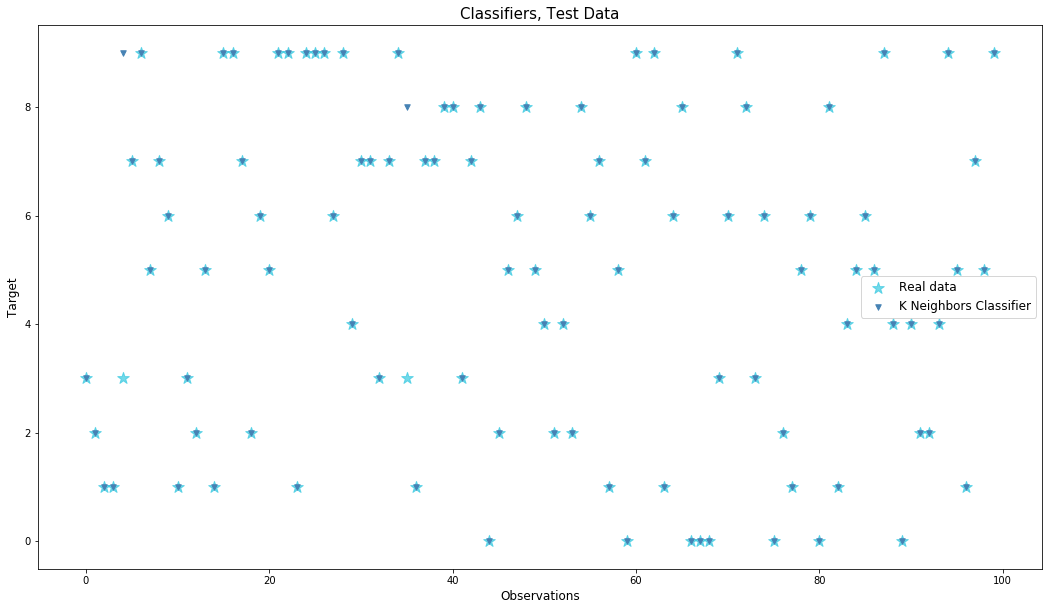

In [208]:
plt.figure(figsize=(18, 10))
n=100
x=range(n)

plt.scatter(x, y_test_num[:n], marker='*', s=150, color='#37c9e1', alpha=0.7, label='Real data')

plt.scatter(x, y_knc_test[:n], marker='v', s=30, color='steelblue', label='K Neighbors Classifier')
# plt.scatter(x, y_lrcvc_test[:n], marker='s', s=30, color='darkblue', label='Logistic RegressionCV')
# plt.scatter(x, y_gbc_test[:n], marker='o', s=30, color='darkgreen', label='GradientBoostingClassifier')

plt.xlabel('Observations', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title('Classifiers, Test Data', fontsize=15)
plt.legend(loc=5, fontsize=12);

## Applications

In [52]:
vgg16_base_model = VGG16(weights='imagenet', include_top=False)
X_train_bn = vgg16_base_model.predict(X_train_app)
X_test_bn = vgg16_base_model.predict(X_test_app)

In [57]:
X_train_bn.shape

(33600, 1, 1, 512)

In [54]:
np.save('X_train_bn.npy', X_train_bn.reshape(X_train_bn.shape[0], X_train_bn.shape[3]))
np.save('X_test_bn.npy', X_test_bn.reshape(X_test_bn.shape[0], X_test_bn.shape[3]))

In [56]:
X_train_bn = np.load('X_train_bn.npy')
X_test_bn = np.load('X_test_bn.npy')
X_train_bn = X_train_bn.reshape(X_train_bn.shape[0], 1, 1, X_train_bn.shape[1])
X_test_bn = X_test_bn.reshape(X_test_bn.shape[0], 1, 1, X_test_bn.shape[1])

In [79]:
def vgg16_add_model():
    model = Sequential()
    model.add(GlobalMaxPooling2D(input_shape=X_train_bn.shape[1:]))

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [80]:
vgg16_add_model = vgg16_add_model()
vgg16_checkpointer = ModelCheckpoint(filepath='weights.best.vgg16.digits.hdf5', 
                                     verbose=2, save_best_only=True)

In [81]:
vgg16_add_history = vgg16_add_model.fit(X_train_bn, y_train, 
                                        validation_data=(X_test_bn, y_test),
                                        epochs=50, batch_size=128, 
                                        callbacks=[vgg16_checkpointer], verbose=0);

Epoch 00000: val_loss improved from inf to 1.47042, saving model to weights.best.vgg16.digits.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 1.47042 to 1.29615, saving model to weights.best.vgg16.digits.hdf5
Epoch 00003: val_loss improved from 1.29615 to 1.17749, saving model to weights.best.vgg16.digits.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 1.17749 to 1.08553, saving model to weights.best.vgg16.digits.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 1.08553 to 1.04583, saving model to weights.best.vgg16.digits.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 1.04583 to 0.98698, saving model to weights.best.vgg16.digits.hdf5
Epoch 00011: val_loss improved from 0.98698 to 0.98263, saving model to weights.best.vgg16.digits.hdf5
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss improved from 0.98263 to 0.98091,

In [83]:
vgg16_add_model.load_weights('weights.best.vgg16.digits.hdf5')
vgg16_test_scores = vgg16_add_model.evaluate(X_test_bn, y_test)
print("Accuracy: %.2f%%" % (vgg16_test_scores[1]*100))

8384/8400 [============================>.] - ETA: 0sAccuracy: 69.96%


## Predictions

In [84]:
predict_labels_cnn = cnn_mc_model.predict(test_images.reshape(28000,28,28,1))
predict_labels_cnn = predict_labels_cnn.argmax(axis=-1)
predict_labels_cnn[:100]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1,
       5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7,
       8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0,
       1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0,
       6, 6, 1, 4, 3, 9, 7, 4])

In [132]:
predict_labels_mlp = mlp_mc_model.predict_classes(test_images)
predict_labels_mlp[:100]

27840/28000 [============================>.] - ETA: 0s   

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1,
       5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7,
       8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0,
       1, 6, 5, 8, 8, 2, 8, 8, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0,
       6, 6, 1, 4, 3, 9, 7, 4])

In [114]:
predict_labels_rnn = rnn_mc_model.predict_classes(test_images.reshape(28000,1,784))
predict_labels_rnn[:100]

28000/28000 [==============================] - 32s       

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1,
       5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7,
       8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0,
       1, 6, 5, 8, 8, 2, 8, 3, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0,
       6, 6, 1, 4, 3, 9, 7, 4])

In [120]:
predict_labels_mlpc = clf.predict(test_images)
predict_labels_mlpc_num = np.array([np.argmax(x) for x in predict_labels_mlpc])
predict_labels_mlpc_num[:100]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1,
       5, 7, 4, 2, 7, 4, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7,
       8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0,
       1, 6, 5, 8, 8, 2, 8, 0, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0,
       6, 6, 1, 4, 3, 9, 7, 4])

In [85]:
submission_cnn = pd.DataFrame({"ImageId": range(1, len(predict_labels_cnn)+1), 
                               "Label": predict_labels_cnn})
print(submission_cnn[0:20])
submission_cnn.to_csv('kaggle_digits_cnn_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      0
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [44]:
submission_mlp = pd.DataFrame({"ImageId": range(1, len(predict_labels_mlp)+1), 
                               "Label": predict_labels_mlp})
print(submission_mlp[:20])
submission_mlp.to_csv('kaggle_digits_mlp_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [118]:
submission_rnn = pd.DataFrame({"ImageId": range(1, len(predict_labels_rnn)+1), 
                               "Label": predict_labels_rnn})
print(submission_rnn[0:20])
submission_rnn.to_csv('kaggle_digits_rnn_mc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [122]:
submission_mlpc = pd.DataFrame({"ImageId": range(1, len(predict_labels_mlpc_num)+1), 
                                "Label": predict_labels_mlpc_num})
print(submission_mlpc[0:20])
submission_mlpc.to_csv('kaggle_digits_mlpc_model.csv', index=False)

    ImageId  Label
0         1      2
1         2      0
2         3      9
3         4      9
4         5      3
5         6      7
6         7      0
7         8      3
8         9      0
9        10      3
10       11      5
11       12      7
12       13      4
13       14      0
14       15      4
15       16      3
16       17      3
17       18      1
18       19      9
19       20      0


In [86]:
real_data = np.array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3,
                      5, 7, 4, 0, 4, 3, 3, 1, 9, 0,
                      9, 1, 1, 5, 7, 4, 2, 7, 4, 7,
                      7, 5, 4, 2, 6, 2, 5, 5, 1, 6,
                      7, 7, 4, 9, 8, 7, 8, 2, 6, 7,
                      6, 8, 8, 3, 8, 2, 1, 2, 2, 0,
                      4, 1, 7, 0, 0, 0, 1, 9, 0, 1,
                      6, 5, 8, 8, 2, 8, 9, 9, 2, 3,
                      5, 4, 1, 0, 9, 2, 4, 3, 6, 7,
                      2, 0, 6, 6, 1, 4, 3, 9, 7, 4,
                      0, 9, 2, 0, 7, 3, 0, 5, 0, 8,
                      0, 0, 4, 7, 1, 7, 1, 1, 3, 3,
                      3, 7, 2, 8, 6, 3, 8, 7, 7, 4,
                      3, 5, 4, 0, 0, 0, 3, 1, 3, 6,
                      4, 3, 4, 5, 5, 8, 7, 4, 2, 8,
                      4, 3, 5, 6, 5, 3, 7, 5, 7, 8,
                      3, 0, 4, 5, 1, 3, 7, 6, 3, 0,
                      2, 7, 8, 6, 1, 3, 7, 4, 1, 2,
                      4, 8, 5, 2, 4, 9, 2, 1, 6, 0,
                      6, 1, 4, 9, 6, 0, 9, 7, 6, 9,
                      1, 9, 0, 9, 9, 0, 8, 4, 6, 2,
                      0, 9, 3, 6, 3, 2, 1, 6, 3, 4,
                      2, 3, 1, 2, 2, 0, 4, 6, 1, 0,
                      0, 4, 9, 1, 7, 3, 2, 3, 8, 6,
                      8, 6, 2, 8, 5, 5, 4, 8, 3, 5,
                      9, 7, 1, 3, 8, 4, 5, 1, 4, 5,
                      6, 3, 3, 5, 7, 0, 6, 8, 3, 1,
                      6, 0, 6, 3, 9, 5, 1, 5, 8, 4,
                      0, 9, 2, 0, 5, 3, 7, 1, 9, 9,
                      5, 7, 7, 9, 9, 6, 3, 0, 3, 3])

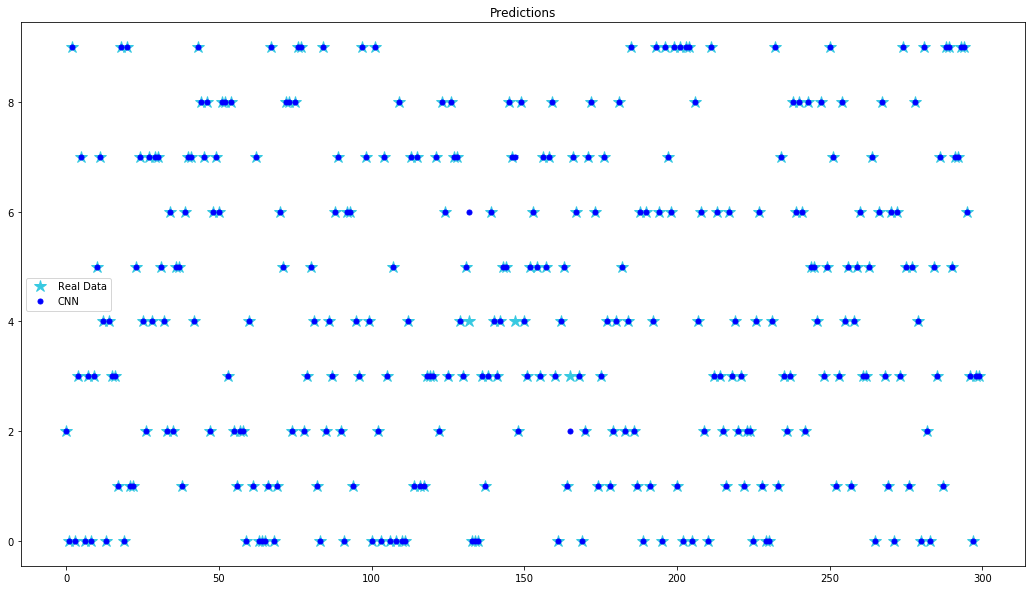

In [87]:
plt.figure(figsize = (18, 10))

plt.plot(real_data[0:300], '*', ms=12, c='#37c9e1', label='Real Data')

plt.plot(submission_cnn['Label'][0:300], 'bo', ms=5, label='CNN')
# plt.plot(submission_mlp['Label'][0:200], 'v', ms=5, label='MLP')
# plt.plot(submission_rnn['Label'][0:200], 's', ms=5, label='RNN')
# plt.plot(submission_mlpc['Label'][0:200], 'p', ms=5, label='MLPC')

plt.legend(loc=6)
plt.title("Predictions");

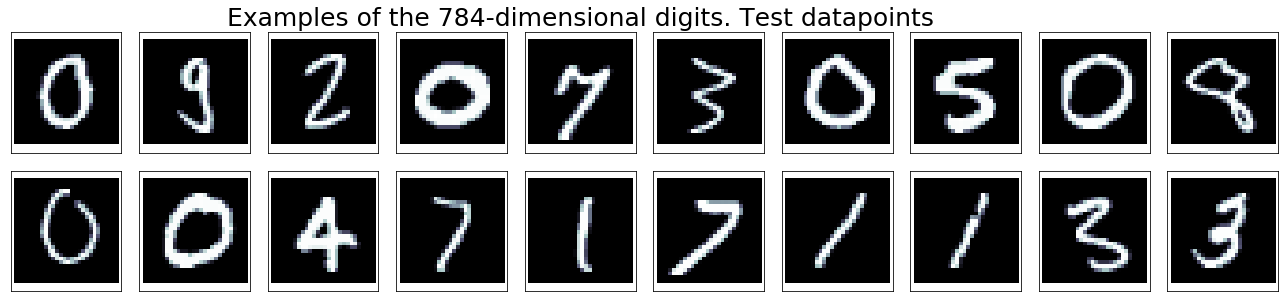

In [74]:
fig, ax = plt.subplots(figsize=(18, 4), nrows=2, ncols=10, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(20):
    image = test_images[100:120][i].reshape(28,28)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[4].set_title('Examples of the 784-dimensional digits. Test datapoints', fontsize=25);